In [2]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import re
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from scipy.stats import norm, skew,stats,johnsonsu
warnings.filterwarnings('ignore')


In [3]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [4]:
PATH="../input/"
os.listdir(PATH)

['test_a.csv',
 'test_a_READ.csv',
 'test_clean1.csv',
 'train_clean1.csv',
 'train_data.csv',
 'train_data_READ.csv']

In [5]:
%%time
train_df = pd.read_csv(PATH+"train_data.csv",index_col=['ID'])
test_df = pd.read_csv(PATH+"test_a.csv", index_col=['ID'])
target = train_df.tradeMoney

Wall time: 337 ms


# <a id='3'>Data exploration</a>  

## <a id='31'>Check the data</a>  

Let's check the train and test set.

In [6]:
print ("Train: ",train_df.shape[0],"sales, and ",train_df.shape[1],"features")
print ("Test: ",test_df.shape[0],"sales, and ",test_df.shape[1],"features")

Train:  41440 sales, and  50 features
Test:  2469 sales, and  49 features


In [7]:
train_df.head(5)

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,RG00001,...,0,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0
100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,RG00002,...,0,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0
100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,RG00002,...,0,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0
100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,RG00002,...,332760000,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0
100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,RG00003,...,0,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0


In [8]:
test_df.head(5)

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime
ID,,,,,,,,,,,,,,,,,,,,,
100000079,36.54,未知方式,1室1厅1卫,高,21,西北,其他,XQ03867,SH,RG00012,...,0.00,0,0.0,41503,319,301635,1601.0,397.0,2,2018/10/25
100000138,64.00,未知方式,2室1厅1卫,高,11,南北,其他,XQ00821,SH,RG00002,...,0.00,0,0.0,4370,0,306857,21123.0,3066.0,0,2018/8/19
100000192,98.00,未知方式,3室1厅1卫,高,6,暂无数据,精装,XQ00842,SH,RG00002,...,0.00,0,0.0,4370,0,306857,17471.0,2554.0,0,2018/3/4
100000200,43.45,未知方式,1室1厅1卫,高,6,暂无数据,其他,XQ00786,SH,RG00002,...,0.00,0,0.0,4370,0,306857,19231.0,2016.0,0,2018/2/3
100000430,92.00,未知方式,2室2厅1卫,高,6,暂无数据,其他,XQ01201,SH,RG00002,...,237828.35,1078790000,4536.0,20904,0,245872,26189.0,2957.0,0,2018/3/14


In [9]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [10]:
%%time
missing_data(train_df)

Wall time: 214 ms


,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,18,18,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0434363,0.0434363,0,0,0
Types,float64,object,object,object,int64,object,object,object,object,object,...,int64,float64,int64,int64,int64,float64,float64,int64,object,float64


Text(0.5,0,'house Loyality (Skewed)')

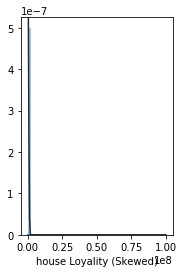

In [11]:
plt.subplot(1, 2, 2)
sns.distplot(target, kde=True, fit = norm)
plt.xlabel('house Loyality (Skewed)')

In [12]:
# set target as nan
test_df['tradeMoney'] = np.nan

# merge                                                                                                                                                           
df = train_df.append(test_df)
df = df.drop(['city'],axis=1)

In [13]:
df.replace(to_replace='暂无信息',value=np.nan,inplace=True)
df.replace(to_replace='未知方式',value=np.nan,inplace=True)
df.replace(to_replace='暂无数据',value=np.nan,inplace=True)
#df.replace(to_replace='其他',value=np.nan,inplace=True)
df.replace(to_replace='--',value=np.nan,inplace=True)

In [14]:
#houseFloor
df.replace(to_replace='高',value=3,inplace=True)
df.replace(to_replace='中',value=2,inplace=True)
df.replace(to_replace='低',value=1,inplace=True)
df['houseFloor'] = df['houseFloor'].astype(int)

In [15]:
#rentType
df.replace(to_replace='整租',value=2,inplace=True)
df.replace(to_replace='合租',value=1,inplace=True)
df['rentType'] = df['rentType'].fillna(df['rentType'].mean()).astype(int)

In [16]:
df.replace(to_replace='西',value=1,inplace=True)
df.replace(to_replace='西北',value=2,inplace=True)
df.replace(to_replace='北',value=3,inplace=True)
df.replace(to_replace='西南',value=4,inplace=True)
df.replace(to_replace='东',value=5,inplace=True)
df.replace(to_replace='东西',value=5,inplace=True)
df.replace(to_replace='东南',value=6,inplace=True)
df.replace(to_replace='南',value=7,inplace=True)
df.replace(to_replace='南北',value=7,inplace=True)
df['houseToward'] = df['houseToward'].fillna(df['houseToward'].mean()).astype(int)

In [17]:
df['houseToward'].describe()

count    43909.000000
mean         6.656357
std          1.036390
min          1.000000
25%          7.000000
50%          7.000000
75%          7.000000
max          7.000000
Name: houseToward, dtype: float64

In [18]:
#houseDecoration
'''df.replace(to_replace='精装',value=2,inplace=True)
df.replace(to_replace='简装',value=1,inplace=True)
df.replace(to_replace='毛坯',value=0,inplace=True)
df['houseDecoration'] = df['houseDecoration'].fillna(df['houseDecoration'].mean()).astype(int)'''

"df.replace(to_replace='精装',value=2,inplace=True)\ndf.replace(to_replace='简装',value=1,inplace=True)\ndf.replace(to_replace='毛坯',value=0,inplace=True)\ndf['houseDecoration'] = df['houseDecoration'].fillna(df['houseDecoration'].mean()).astype(int)"

In [19]:
#buildYear
df['buildYear'] = df['buildYear'].where(df['buildYear'].notnull(), 0)
df['buildYear'] = df['buildYear'].astype(int)

df['buildYear'].replace(to_replace=0,value=np.nan,inplace=True)
df['buildYear'] = df['buildYear'].fillna(df['buildYear'].mean()).astype(int)


In [20]:
df['uv'] = df['uv'].fillna(df['uv'].mean()).astype(int)
df['pv'] = df['pv'].fillna(df['pv'].mean()).astype(int)

In [21]:
#tradeTime
df["tradeTime"] = pd.to_datetime(df["tradeTime"])
df["month"] = df["tradeTime"].dt.month
df["year"] = df["tradeTime"].dt.year
df['week'] = df["tradeTime"].dt.weekofyear
df['dayofweek'] = df['tradeTime'].dt.dayofweek
df['days'] = (datetime.date(2019, 5, 1) - df['tradeTime'].dt.date).dt.days
df['quarter'] = df['tradeTime'].dt.quarter
#df['is_month_start'] = df['tradeTime'].dt.is_month_start

df = df.drop(['tradeTime'],axis=1)

In [22]:
#houseType
df['rooms'] = df['houseType'].str.extract(r'(\d+室)', expand=False).apply(lambda x: eval(x.split('室')[0]))
df['halls'] = df['houseType'].str.extract(r'(\d+厅)', expand=False).apply(lambda x: eval(x.split('厅')[0]))
df['toilet'] = df['houseType'].str.extract(r'(\d+卫)', expand=False).apply(lambda x: eval(x.split('卫')[0]))
df = df.drop(['houseType'],axis=1)

In [23]:
agg_func = {
        'buildYear' : ['max','min'],
    
        'subwayStationNum': ['sum', 'mean', 'max', 'min'],
        'busStationNum': ['sum', 'mean', 'max', 'min'],
        'interSchoolNum': ['sum', 'mean', 'max', 'min'],
        'schoolNum': ['sum', 'mean', 'max', 'min'],
        'privateSchoolNum': ['sum', 'mean', 'max', 'min'],
        'hospitalNum': ['sum', 'mean', 'max', 'min'],
        'drugStoreNum': ['sum', 'mean', 'max', 'min'],
        'gymNum': ['sum', 'mean', 'max', 'min'],
        'bankNum': ['sum', 'mean', 'max', 'min'],
        'shopNum': ['sum', 'mean', 'max', 'min'],
        'parkNum': ['sum', 'mean', 'max', 'min'],
        'mallNum': ['sum', 'mean', 'max', 'min'],
        'superMarketNum': ['sum', 'mean', 'max', 'min'],
        'lookNum': ['sum', 'mean', 'max', 'min'],
    
        'pv': ['max','min','mean'],
        'uv': ['max','min','mean'],
    
        'month': ['nunique'],
        'dayofweek': ['nunique'],
        'year': ['nunique'],
        'communityName': ['nunique'],
        'region' : ['nunique'],
        'plate' : ['nunique'],
    }
    
agg_trans = df.groupby(['ID']).agg(agg_func)
agg_trans.columns = [ '_'.join(col).strip() 
                           for col in agg_trans.columns.values]
agg_trans.reset_index(inplace=True)
df = pd.merge(df, agg_trans, on='ID', how='left')

df = df.drop(['communityName'],axis=1)
df = df.drop(['plate'],axis=1)
df = df.drop(['region'],axis=1)
df = df.drop(['rentType'],axis=1)

In [24]:
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
print(categorical_columns)

['houseDecoration']


In [25]:
df, cols = one_hot_encoder(df, nan_as_category=False)

In [26]:
df.head(5)

,ID,area,houseFloor,totalFloor,houseToward,buildYear,saleSecHouseNum,subwayStationNum,busStationNum,interSchoolNum,...,month_nunique,dayofweek_nunique,year_nunique,communityName_nunique,region_nunique,plate_nunique,houseDecoration_其他,houseDecoration_毛坯,houseDecoration_简装,houseDecoration_精装
0,100309852,68.06,1,16,6,1953,0,7,36,0,...,1,1,1,1,1,1,1,0,0,0
1,100307942,125.55,2,14,6,2007,0,2,184,0,...,1,1,1,1,1,1,0,0,1,0
2,100307764,132.00,1,32,6,1999,3,6,60,1,...,1,1,1,1,1,1,1,0,0,0
3,100306518,57.00,2,17,6,1999,0,3,364,2,...,1,1,1,1,1,1,0,0,0,1
4,100305262,129.00,1,2,6,1999,1,0,141,0,...,1,1,1,1,1,1,0,1,0,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43909 entries, 0 to 43908
Columns: 126 entries, ID to houseDecoration_精装
dtypes: float64(8), int32(12), int64(102), uint8(4)
memory usage: 39.4 MB


In [28]:
missing_data(df)

,ID,area,houseFloor,totalFloor,houseToward,buildYear,saleSecHouseNum,subwayStationNum,busStationNum,interSchoolNum,...,month_nunique,dayofweek_nunique,year_nunique,communityName_nunique,region_nunique,plate_nunique,houseDecoration_其他,houseDecoration_毛坯,houseDecoration_简装,houseDecoration_精装
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,int64,float64,int64,int64,int32,int32,int64,int64,int64,int64,...,int64,int64,int64,int64,int64,int64,uint8,uint8,uint8,uint8


In [29]:
FEATS_EXCLUDED = [
    "ID","tradeMoney"
    ]

In [ ]:
features = [c for c in df.columns if c not in FEATS_EXCLUDED]

df['area'] = np.log1p(df['area'])

for i in features:
    if df[i].mean() > 5000:
        #print(i)
        df[i] = np.log1p(df[i])

In [30]:
train_df = df[df['tradeMoney'].notnull()].to_csv("train_clean41.csv",encoding="gbk",index = False)
test_df = df[df['tradeMoney'].isnull()].to_csv("test_clean41.csv",encoding="gbk" ,index = False)